# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

df.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


## Разбейте данные на выборки

In [3]:
#разделим данные на признаки и цели 
features = df.drop(columns='is_ultra', axis=1)
target = df['is_ultra']

In [4]:
#Разделим признаки и цели на: основные 60% (f_train,t_tain), вилидационные 20% (f_valid,t_valid), тестовые 20% (f_test,t_test)

f, features_valid, t, target_valid = train_test_split(features, target, test_size=0.20, random_state=12345)

features_train, features_test, target_train, target_test = train_test_split(f,t, test_size=0.25, random_state=12345)

## Исследуйте модели

In [5]:
# Создадим функцию для проверки сразу всех моделей с разными гиперпараметрами которая вернёт нам датафрэйм с колонками 'models'
# и'results' в которых будут лучшие модели и их результаты.
def test_models(f_train, t_train, f_valid, t_valid):
    depth = 1
    estimators = 1
    
    def metod_list_form(depth, estimators):
        metod_list = [[DecisionTreeClassifier(random_state=12345, max_depth=depth),11,2],
                      [RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimators),11,51],
                      [LogisticRegression(random_state=12345),2,2]]
        return metod_list
    
    result_df = pd.DataFrame(columns=['models','results'])
    metod_list = metod_list_form(depth, estimators)
    
    for i in range(len(metod_list)):
        best_model = None
        best_result = 0
        
        for depth in range(1, metod_list[i][1]):
            
            for estimators in range(1, metod_list[i][2]):
                model = metod_list[i][0]
                model.fit(f_train,t_train) 
                predictions = model.predict(f_valid) 
                result = accuracy_score(t_valid, predictions) 
                metod_list = metod_list_form(depth, estimators)
                
                if result > best_result:
                    best_model = model
                    best_result = result
                    
        result_df.loc[len(result_df.index)] = [best_model,best_result] 
    return result_df
                       

In [6]:
best_top_models = test_models(features_train, target_train, features_valid, target_valid) #вызываем функию для проверки

# выводим получившиеся результаты
print(best_top_models['models'][0],': ',best_top_models['results'][0])
print(best_top_models['models'][1],': ',best_top_models['results'][1])
print(best_top_models['models'][2],': ',best_top_models['results'][2])

DecisionTreeClassifier(max_depth=5, random_state=12345) :  0.7884914463452566
RandomForestClassifier(max_depth=7, n_estimators=3, random_state=12345) :  0.80248833592535
LogisticRegression(random_state=12345) :  0.7589424572317263


По результатам  исследования лучше всего себя показала модель рандомного леса с гиперпараметрами max_depth=7 и n_estimators=3,
на втором месте дерево решений, и на третьем месте модель логической регрессии. 

In [7]:
# Выделяем лучшую модель 
best_top_models = best_top_models.sort_values('results', ascending=False ).head(1).reset_index(drop=True)['models'][0]

## Проверьте модель на тестовой выборке

In [8]:
# Проверяем лучшую модель на тестовой выборке
model = best_top_models
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)

print('Точнось предсказания для тестовой выборки:',accuracy)


Точнось предсказания для тестовой выборки: 0.776049766718507


Точно предсказания составила более 0.77 при необходимых 0.75 это нас устраивает.

## (бонус) Проверьте модели на адекватность

Проверим как покажет себя константная модель.

<AxesSubplot:ylabel='is_ultra'>

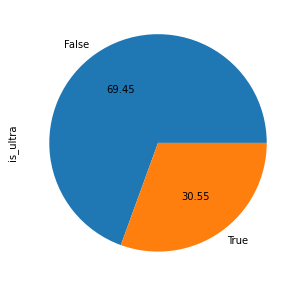

In [9]:
#выясняем какие ответы встречаются чаще 
target_train.groupby(target_train > 0).count().plot(kind='pie', autopct="%.2f", figsize=(5,5)) 

In [10]:
# Создадим константную выборку с значением 0 
target_const = pd.Series([0]*len(target_valid)) 

# Проверяем точно константной выборки
accuracy = accuracy_score(target_valid, target_const)

print('Точность константной модели:',accuracy)

Точность константной модели: 0.6951788491446346


Все модели оказались точнее константной модели. 